In [130]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from pathlib import Path

def generate_nodes_and_edges(edges_file: Path) -> tuple:
    nodes = set()
    edges = []
    with edges_file.open() as edges_f:
        for i, line in enumerate(edges_f):
            # if the first line is the title, skip it
            if i == 0:
                continue
            line = line.strip()
            endpoints = line.split(" ")
            if len(endpoints) != 3:
                raise ValueError(f"Edge {line} does not contain 2 nodes separated by ' ' and a weight")
            nodes.add(endpoints[0])
            nodes.add(endpoints[1])
            edges.append((endpoints[0], endpoints[1], endpoints[2]))
    return nodes, edges

def generate_graph(nodes, edges) -> nx.DiGraph:
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(edges)
    return G

def generate_nodes(nodes_file: Path) -> list:
    """
    This function is for generating the nodes from the path to the source/target file
    """
    nodes = []
    with nodes_file.open() as nodes_f:
        for i, line in enumerate(nodes_f):
            # if the first line is the title, skip it
            if i == 0:
                continue
            line = line.strip()
            endpoints = line.split(" ")
            if len(endpoints) != 2:
                raise ValueError(f"Node {line} does not contain 1 node and a prize")
            # (node, prize)
            nodes.append((endpoints[0], endpoints[1]))
    return nodes

def generate_personalization_vector(nodes : list) -> dict:
    """
    This function is for generating the personalization vector from the source/target file
    """
    personalization_vector = {}
    # assigning value 1 to the source and target nodes to pass it to the random walk function
    for i in nodes:
        if type(i) == tuple:
            personalization_vector[i[0]] = float(i[1]) 
        else:
            personalization_vector[i] = 1.0
    
    return personalization_vector

def pathway_construction(G : nx.DiGraph, final_pr : dict, alpha : float, source_node, target_node):
    """
    Return a subnetwork of G where for each edge of it, both ends are in the subset of interest.
    
    """
 
    linker_nodes = set()
    filtered_nodes = set()
    for key in final_pr:
        if final_pr[key] > alpha:
            print(f'Adding {key} (PR = {final_pr[key]}) to filtered nodes.')
            linker_nodes.add(key)
    if type(source_node) == list and type(target_node) == list:
        source_set = set([i[0] for i in source_node])
        target_set = set([i[0] for i in target_node])
    else:
        source_set = source_node
        target_set = target_node
    filtered_nodes = set(source_set).union(set(target_set)).union(set(linker_nodes))
    print(f'Filtered nodes: {filtered_nodes}')
 
    linker_nodes = filtered_nodes - source_set - target_set
    edgelist = set()
 
    for u in G.edges().keys():
        if u[0] in filtered_nodes and u[1] in filtered_nodes:
            print(f'Adding edge {u}')
            edgelist.add(u)

    return edgelist, linker_nodes, source_set, target_set

    # Read the list of sources

def calculate_rwwr(G : nx.DiGraph, source_node : Path, target_node : Path, threshold) -> tuple:
    """
    This function is for calculating the RWR score
    """

    pr = nx.pagerank(G, alpha=0.85, personalization=generate_personalization_vector(source_node))
        
    # Create the reverse graph
    R = G.reverse()
    # Running pagerank on the reverse graph with T as the personalization vector
    r_pr = nx.pagerank(R, alpha=0.85, personalization=generate_personalization_vector(target_node))

    final_pr = {}

    for i in pr:
        'Let user decide how to combine the two pageranks'
        final_pr[i] = min(pr[i], r_pr[i])

    edgelist, linker_nodes, source_set, target_set = pathway_construction(G, final_pr, threshold, source_node, target_node)
    print(edgelist)

    return edgelist, linker_nodes, source_set, target_set


def draw_rwwr(G, edgelist, linker_nodes, source_set, target_set):
    """
    This function is for drawing the graph
    """
    
    pos = nx.circular_layout(G)  # positions for all nodes


    nodes = set(G.nodes())

    # nodes
    options = {"edgecolors": "tab:gray", "node_size": 500, "alpha": 0.9}
    nx.draw_networkx_nodes(G, pos, nodelist= source_set, node_color="tab:red", **options)
    nx.draw_networkx_nodes(G, pos, nodelist=target_set, node_color="tab:blue", **options)
    nx.draw_networkx_nodes(G, pos, nodelist=nodes - source_set - target_set, node_color="tab:gray", **options)
    nx.draw_networkx_nodes(G, pos, nodelist=linker_nodes, node_color="tab:green", **options)

    # edges
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=edgelist,
        width=3,
        alpha=0.5,
        edge_color="tab:red",
    )


    # # some math labels
    labels = {}
    for i in nodes:
        labels[i] = i
    nx.draw_networkx_labels(G, pos, labels, font_size=16, font_color="whitesmoke")

    plt.tight_layout()
    plt.axis("off")
    plt.show()

Adding D (PR = 0.3304163279621552) to filtered nodes.
Filtered nodes: {'E', 'C', 'D', 'F', 'A', 'G', 'B'}
Adding edge ('C', 'D')
Adding edge ('B', 'D')
Adding edge ('D', 'E')
Adding edge ('D', 'F')
Adding edge ('D', 'G')
Adding edge ('A', 'D')
{('D', 'G'), ('A', 'D'), ('B', 'D'), ('C', 'D'), ('D', 'E'), ('D', 'F')}


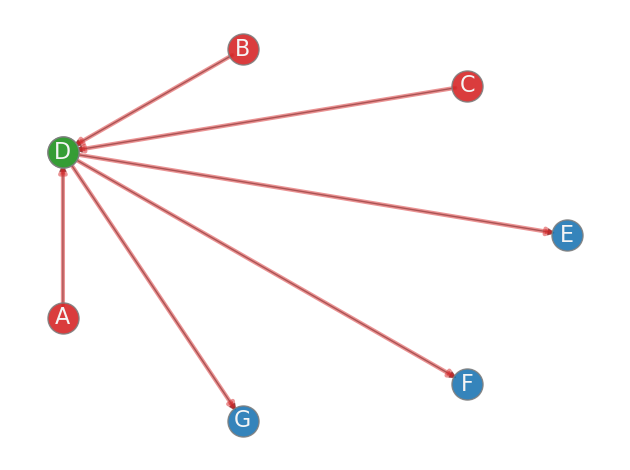

In [131]:
edges_file = Path("./input/edges.txt")
source_file = Path("./input/source_nodes.txt")
target_file = Path("./input/target_nodes.txt")
threshold = 0.3

nodes, edges = generate_nodes_and_edges(edges_file)
source_nodes, target_nodes = generate_nodes(source_file), generate_nodes(target_file)
G = generate_graph(nodes, edges)
edgelist, linker_nodes, source_set, target_set = calculate_rwwr(G, source_nodes, target_nodes, threshold)
draw_rwwr(G, edgelist, linker_nodes, source_set, target_set)

Adding E (PR = 0.09421972981817603) to filtered nodes.
Adding G (PR = 0.2157958357014219) to filtered nodes.
Filtered nodes: {'E', 'C', 'N', 'B', 'L', 'K', 'D', 'A', 'G', 'F'}
Adding edge ('E', 'F')
Adding edge ('E', 'G')
Adding edge ('B', 'E')
Adding edge ('B', 'F')
Adding edge ('K', 'G')
Adding edge ('D', 'G')
Adding edge ('A', 'E')
Adding edge ('G', 'C')
Adding edge ('G', 'L')
Adding edge ('G', 'N')
Adding edge ('F', 'G')
{('B', 'E'), ('K', 'G'), ('B', 'F'), ('E', 'G'), ('D', 'G'), ('G', 'C'), ('G', 'N'), ('F', 'G'), ('G', 'L'), ('A', 'E'), ('E', 'F')}


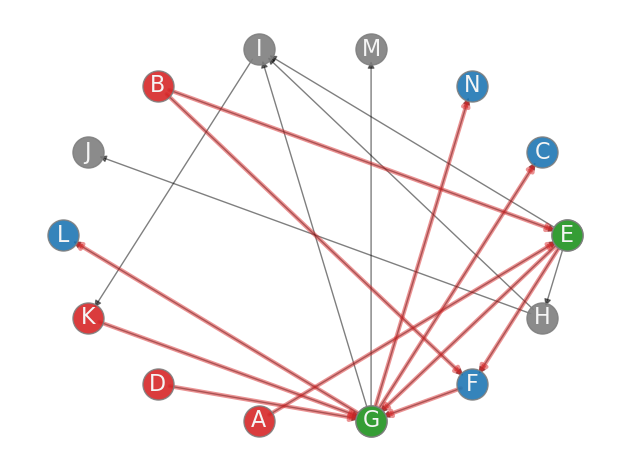

In [132]:
edges_file = Path("./input/edges1.txt")
source_file = Path("./input/source_nodes1.txt")
target_file = Path("./input/target_nodes1.txt")
threshold = 0.09
nodes, edges = generate_nodes_and_edges(edges_file)
source_nodes, target_nodes = generate_nodes(source_file), generate_nodes(target_file)
G = generate_graph(nodes, edges)
edgelist, linker_nodes, source_set, target_set = calculate_rwwr(G, source_nodes, target_nodes, threshold)
draw_rwwr(G, edgelist, linker_nodes, source_set, target_set)


Adding 4 (PR = 0.04498546680196544) to filtered nodes.
Adding 6 (PR = 0.04116489638790646) to filtered nodes.
Adding 16 (PR = 0.06477419543404128) to filtered nodes.
Filtered nodes: {0, 2, 3, 4, 5, 6, 11, 13, 14, 15, 16}
Adding edge (2, 4)
Adding edge (4, 16)
Adding edge (5, 16)
Adding edge (11, 2)
Adding edge (13, 15)
Adding edge (16, 5)
Adding edge (16, 14)
{(2, 4), (4, 16), (16, 14), (11, 2), (5, 16), (16, 5), (13, 15)}


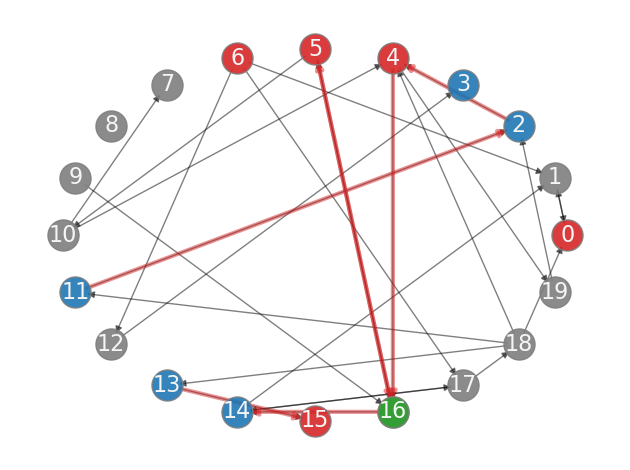

In [133]:
G = nx.fast_gnp_random_graph(20, 0.1, directed=True)
threshold = 0.04
nodes = set(G.nodes())
source_nodes = set(random.sample(G.nodes(), 5))
target_nodes = set(random.sample(nodes - source_nodes, 5))
edgelist, linker_nodes, source_set, target_set = calculate_rwwr(G, source_nodes, target_nodes, threshold)
draw_rwwr(G, edgelist, linker_nodes, source_set, target_set)